# MapMatching Example for enviroCar Tracks

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import pandas as pd
import geopandas as gpd

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

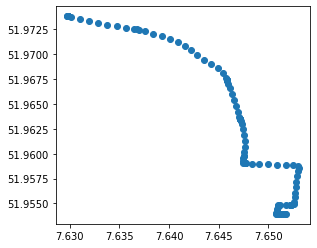

In [2]:
bbox = BboxSelector([
    7.601165771484375, # min_x
    51.94807412325402, # min_y
    7.648200988769531, # max_x
    51.97261482608728  # max_y
])

# Requesting a single track
track_df = track_api.get_tracks(bbox=bbox, num_results=1)
track_df.plot()

## Creating the Graph Network

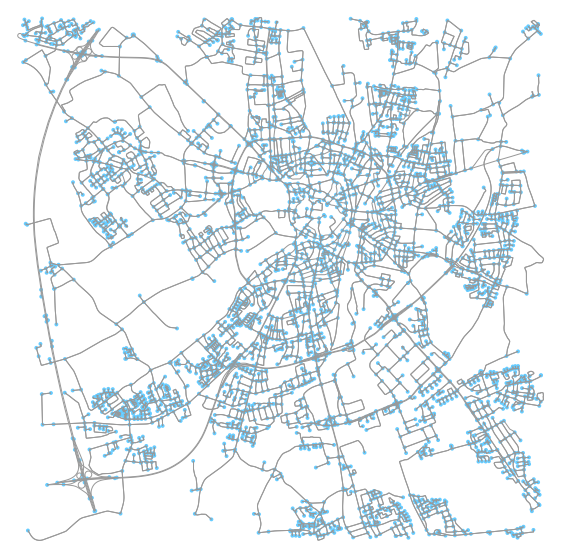

CPU times: user 10.2 s, sys: 384 ms, total: 10.6 s
Wall time: 12.5 s


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa73787ce48>)

In [3]:
%%time
import numpy as np
import osmnx as ox

lat = 51.950296032982756
lng = 7.615756988525391

# Get the OSM graph of "drive" streets for münster an plot it
graph = ox.graph_from_point((lat, lng), dist=5000, network_type='drive')
ox.plot_graph(graph, fig_height=10, fig_width=10)

In [4]:
from leuvenmapmatching.matcher.distance import DistanceMatcher
from leuvenmapmatching.map.inmem import InMemMap

# Leuven Map Matching is using a different internal graph structure for the street data. 
# Therefore, the OSMnx graph needs to be transformed to the InMemMap
streetmap = InMemMap("enviroCar", use_latlon=True, use_rtree=True, index_edges=True)

# add nodes
nodes = list(graph.nodes)
for node in nodes:
    lng = graph.nodes[node]['x']
    lat = graph.nodes[node]['y']
    streetmap.add_node(node, (lat, lng))

# add edges
edges = list(graph.edges)
for edge in edges:
    node_a, node_b = edge[0], edge[1]
    streetmap.add_edge(node_a, node_b)
    
    # exclude bi-directional edges when street is oneway
    if not graph.edges[edge]['oneway']:
        streetmap.add_edge(node_b, node_a)
    
streetmap.purge()

/home/hafenkran/dev/envirocar/venv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/home/hafenkran/dev/envirocar/venv/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


## MapMatch the Track

In [5]:
# Get the latitude and longitude coordinates from the track and join them in an array
lats = list(track_df['geometry'].apply(lambda coord: coord.y))
lngs = list(track_df['geometry'].apply(lambda coord: coord.x))

track_coords = [c for c in zip(lats, lngs)]

In [6]:
%%time
# Configure the mapmatcher. For increasing the performance it is important 
# that max_dist (in meters) is not set too high
matcher = DistanceMatcher(streetmap,
                          max_dist=50, 
                          max_dist_init=100,
                          min_prob_norm=0.001,
                          non_emitting_length_factor=0.75,
                          obs_noise=50,
                          obs_noise_ne=75,
                          dist_noise=50,
                          non_emitting_edgeid=False)

# Perform the mapmatching 
edge_ids, last_idx = matcher.match(track_coords)

CPU times: user 536 ms, sys: 3.01 ms, total: 539 ms
Wall time: 537 ms


In [7]:
import folium

lat = 51.950296032982756
lng = 7.615756988525391

# get the coordinates of the "best" mapmatched route
coords = [m.edge_m.pi[:] for m in matcher.lattice_best]

# plot both raw and mapmatched track
m = folium.Map(location=[lat, lng], zoom_start=13)
folium.PolyLine(coords, color='blue').add_to(m)
folium.PolyLine(track_coords, color='red').add_to(m)
m